In [40]:
import numpy as np
import csv
import sqlite3
from pathlib import Path
import rdkit
from rdkit.Chem import Descriptors
import pandas as pd
from plotnine import *
import re
from rdkit import Chem, DataStructs
from rdkit.Chem.Fingerprints import FingerprintMols
from rdkit.Chem import AllChem
from rdkit.Chem import Descriptors
from dbManager import DatabaseManager

# Database Class
Create database connections and tables with data from activity_data.csv

In [41]:
class DatabaseManager():
    def __init__(self, database_path: str):
        """
        Parameters
        ----------
        database_path: str
            Full path of existing SQLite database or one to be created automatically
        """

        # Store SQLite database path for reference
        self._database_path = database_path

        # Connect to and Create (if doesn't already exist) SQLite database
        self._conn = sqlite3.connect(database_path)

        # List of tables that need to be dropped to reset the SQLite database
        self._drop_order = ('assays', 'compounds',)


    def get_conn(self):
        """
        get_conn returns a connection to the SQLite database self._database_path

        Returns
        -------
            SQLite connection object
        """
        return self._conn
    
    def drop_all(self):
        """
        drop_all drops all tables created by this class to reset the SQLite database
        """

        # Get connection to SQLite database
        conn = self.get_conn()

        # Drop all tables in dependency order
        for table_name in self._drop_order:
            conn.execute('DROP TABLE IF EXISTS ' + table_name)


    def create(self):
        """
        create - creates all tables required by this class in the SQLite database
        """

        # Get connection to SQLite database
        conn = self.get_conn()

        # Create a table to store all COVID Moonshot assay data
        conn.execute('''
CREATE TABLE assays
(
    CID VARCHAR(20) PRIMARY KEY,
    r_avg_IC50 DECIMAL,
    f_avg_IC50 DECIMAL,
    trypsin_IC50 DECIMAL,
    acrylamide VARCHAR(5),
    chloroacetamide VARCHAR(5),
    series VARCHAR(30),
    frag_id VARCHAR(6),
    FOREIGN KEY(CID) REFERENCES compounds(CID) 
)
        ''')

        # Create a table to store all COVID Moonshot compound submissions
        conn.execute('''
CREATE TABLE compounds
(
    CID VARCHAR(20) PRIMARY KEY,
    smiles VARCHAR(250) not null,
    NumHDonors REAL,
    NumHAcceptors REAL,
    ExactMolWt REAL,
    MolLogP REAL
)
        ''')


    def populate_compounds_table(self, all_data_file: Path):
        """
        Populate the table compounds by reading out all of the unique submissions from $all_data_file and 
        adding features for Lipinski's rule of 5
        """

        compounds_list = []
        with open(all_data_file, mode = 'r') as csv_file:
            csv_reader = csv.DictReader(csv_file)
            for row in csv_reader:
                compound_id = row["CID"]
                smiles = row["SMILES"]
                mol = rdkit.Chem.MolFromSmiles(smiles)
                NumHDonors = Descriptors.NumHDonors(mol)
                NumHAcceptors = Descriptors.NumHAcceptors(mol)
                ExactMolWt = Descriptors.ExactMolWt(mol)
                MolLogP = Descriptors.MolLogP(mol)
                comp_tuple = (compound_id, smiles, NumHDonors,
                                NumHAcceptors, ExactMolWt,
                                MolLogP)
                if comp_tuple not in compounds_list:
                    compounds_list.append(comp_tuple)

        conn = self.get_conn()
        conn.executemany('''INSERT INTO compounds (CID, SMILES, NumHDonors,
                                NumHAcceptors, ExactMolWt,
                                MolLogP) VALUES(?,?,?,?,?,?)''', compounds_list)

    def populate_assays_table(self, all_data_file: Path):
        """
        Populate the table assays by reading out all of the unique submissions from $all_data_file
        """

        assays_list = []
        with open(all_data_file, mode = 'r') as csv_file:
            csv_reader = csv.DictReader(csv_file)
            for row in csv_reader:
                compound_id = row["CID"]
                r_avg_IC50 = row["r_avg_IC50"]
                f_avg_IC50 = row["f_avg_IC50"]
                trypsin_IC50 = row["trypsin_IC50"]
                acrylamide = row["acrylamide"]
                chloroacetamide = row["chloroacetamide"]
                series = row["series"]
                frag_id = row["frag_id"]
                assay_tuple = (compound_id,
                                r_avg_IC50,
                                f_avg_IC50,
                                trypsin_IC50,
                                acrylamide,
                                chloroacetamide,
                                series,
                                frag_id)
                if assay_tuple not in assays_list:
                    assays_list.append(assay_tuple)

        conn = self.get_conn()
        conn.executemany('INSERT INTO assays (CID, r_avg_IC50, f_avg_IC50,trypsin_IC50,acrylamide,chloroacetamide,series,frag_id) VALUES(?,?,?,?,?,?,?,?)', assays_list)

    def all_data_df(self):
        """
        Extract all compounds from the DB with assay data
        """
        conn = self.get_conn()

        cur = conn.execute('''
            SELECT c.CID, c.smiles,
            a.r_avg_IC50, a.f_avg_IC50, a.trypsin_IC50, a.acrylamide, a.chloroacetamide, a.series, a.frag_id
            FROM
            compounds c LEFT JOIN assays a
            ON
            c.CID = a.CID           
        ''')
        
        # Print the outputs to check query works as intended
        # print("All compounds:\n")
        # for row in cur:
        #     print(row)

        # Return alla compounds as pandas dataframe
        all_comps = pd.DataFrame(cur.fetchall(), columns=['CID', 'smiles', 'r_avg_IC50', 'f_avg_IC50', 'trypsin_IC50',
                                        'acrylamide', 'chloroacetamide', 'series', 'frag_id'])

        return all_comps

    def lipinski_compounds(self):
        """
        Extract all compounds compliant with the Lipinski rule of 5 from the DB
        """
        conn = self.get_conn()

        cur = conn.execute('''
            SELECT c.*,
            a.r_avg_IC50, a.f_avg_IC50, a.trypsin_IC50, a.acrylamide, a.chloroacetamide, a.series, a.frag_id
            FROM
            compounds c LEFT JOIN assays a
            ON
            c.CID = a.CID
            WHERE
            c.NumHDonors <= 5 AND c.NumHAcceptors <= 10 AND c.ExactMolWt < 500 AND c.MolLogP < 5
            
        ''')
        
        # Print the outputs to check query works as intended
        # print("Lipinski compounds:\n")
        # for row in cur:
        #     print(row)

        # Return Lipinski compounds as pandas dataframe
        lipinski_comps = pd.DataFrame(cur.fetchall(), columns=['CID', 'smiles','NumHDonors','NumHAcceptors',
                                        'ExactMolWt', 'MolLogP', 'r_avg_IC50', 'f_avg_IC50', 'trypsin_IC50',
                                        'acrylamide', 'chloroacetamide', 'series', 'frag_id'])

        return lipinski_comps


    def print_table_tops(self):
        """
        REMOVE LATER - Print the first 15 rows of both tables created to test they have been created correctly - REMOVE LATER
        """
        conn = self.get_conn()
        cur_comps = conn.execute('''
            SELECT * FROM compounds LIMIT 15
        ''')

        for row in cur_comps:
            print(row)

        print("\n")

        cur_assays = conn.execute('''
            SELECT * FROM assays LIMIT 15
        ''')

        for row in cur_assays:
            print(row)


# Call database manager methods to create tables 
Create the compound and assay tables from activity_data.csv:

In [42]:
all_data_file = Path('activity_data.csv')

manager = DatabaseManager(database_path='activity_data.db')
manager.drop_all()
manager.create()
manager.populate_compounds_table(all_data_file=all_data_file)
manager.populate_assays_table(all_data_file=all_data_file)


('MAT-POS-be048f2c-5', 'CCn1nccc1C(=O)N1Cc2ccc(Cl)cc2C2(CCN(c3cncc4ccccc34)C2=O)C1', 0.0, 5.0, 485.161852688, 4.435300000000003)
('EDJ-MED-cc48ee33-4', 'Cc1cnn(C)c1C(=O)N1Cc2ccc(Cl)cc2C2(CCN(c3cncc4ccccc34)C2=O)C1', 0.0, 5.0, 485.161852688, 4.260820000000003)
('EDJ-MED-cc48ee33-5', 'Cc1cc(C(=O)N2Cc3ccc(Cl)cc3C3(CCN(c4cncc5ccccc45)C3=O)C2)n(C)n1', 0.0, 5.0, 485.16185268800007, 4.260820000000003)
('MIK-UNK-58cd43d0-1', 'O=C(Nc1cncc2c1CCCC2)[C@H]1CNS(=O)(=O)c2ccc(Cl)cc21', 2.0, 4.0, 391.07574011599996, 2.628000000000001)
('MIK-UNK-78dbf1b8-1', 'O=C(Nc1cncc2c1CCCC2)[C@@H]1CNS(=O)(=O)c2ccc(Cl)cc21', 2.0, 4.0, 391.07574011599996, 2.628000000000001)
('SAL-UNI-60119594-1', 'CC(CCC(OC1OC(COC2OC(CO)C(O)C(O)C2O)C(O)C(O)C1O)C(C)(C)O)C1CCC2(C)C3CC=C4C(CCC(O)C4(C)C)C3(C)C(O)CC12C', 10.0, 14.0, 800.492206984, 1.1198000000000037)
('SAL-UNI-60119594-2', 'COC(C)(C)/C=C/C[C@@H](C)[C@H]1CC[C@@]2(C)[C@@H]3[C@@H](O[C@@H]4O[C@H](CO)[C@@H](O)[C@H](O)[C@H]4O)C=C4[C@@H](CC[C@H](O)C4(C)C)[C@]3(C=O)CC[C@]12C', 5.

# Extract data
Populate a dataframe of all components with assay data for which molecular descriptors can be calculated. lipinski_comps is a dataframe of components satisfying the Lipinski rule of 5 criteria.

In [43]:

all_comps = manager.all_data_df()
lipinski_comps = manager.lipinski_compounds()

manager.get_conn().commit()

all_comps.head()

,CID,smiles,r_avg_IC50,f_avg_IC50,trypsin_IC50,acrylamide,chloroacetamide,series,frag_id
0,MAT-POS-be048f2c-5,CCn1nccc1C(=O)N1Cc2ccc(Cl)cc2C2(CCN(c3cncc4ccc...,,0.297012,,False,False,3-aminopyridine-like,
1,EDJ-MED-cc48ee33-4,Cc1cnn(C)c1C(=O)N1Cc2ccc(Cl)cc2C2(CCN(c3cncc4c...,,0.682988,,False,False,3-aminopyridine-like,
2,EDJ-MED-cc48ee33-5,Cc1cc(C(=O)N2Cc3ccc(Cl)cc3C3(CCN(c4cncc5ccccc4...,,0.463982,,False,False,3-aminopyridine-like,
3,MIK-UNK-58cd43d0-1,O=C(Nc1cncc2c1CCCC2)[C@H]1CNS(=O)(=O)c2ccc(Cl)...,,0.723365,,False,False,3-aminopyridine-like,
4,MIK-UNK-78dbf1b8-1,O=C(Nc1cncc2c1CCCC2)[C@@H]1CNS(=O)(=O)c2ccc(Cl...,,0.205139,,False,False,3-aminopyridine-like,


# Featurization
Featurize the data using all descriptors available in rdkit.descriptors. Then remove features with zero variance.

In [44]:
mol_smiles = all_comps['smiles']

all_descriptors = {d[0]: d[1] for d in Descriptors.descList}

features = {}
for i in range(len(mol_smiles)):
    mol = rdkit.Chem.MolFromSmiles(mol_smiles[i])
    features[i] = {d: all_descriptors[d](mol) for d in all_descriptors}

features = pd.DataFrame.from_dict(features).T
features.head()


,MaxEStateIndex,MinEStateIndex,MaxAbsEStateIndex,MinAbsEStateIndex,qed,MolWt,HeavyAtomMolWt,ExactMolWt,NumValenceElectrons,NumRadicalElectrons,...,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
0,14.277823,-0.872863,14.277823,0.027158,0.429991,485.975,461.783,485.161853,176.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,14.288587,-0.877395,14.288587,0.029261,0.425072,485.975,461.783,485.161853,176.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,14.275766,-0.876264,14.275766,0.029763,0.425072,485.975,461.783,485.161853,176.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,12.921568,-3.613462,12.921568,0.003930,0.823203,391.880,373.736,391.075740,136.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,12.921568,-3.613462,12.921568,0.003930,0.823203,391.880,373.736,391.075740,136.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [45]:
features_cov = features.cov()
vars = pd.DataFrame(np.diagonal(features_cov), index=all_descriptors, columns=['Variance']).sort_values(by='Variance', ascending=False)

features = features.drop(vars[vars['Variance']==0].index.values, axis = 1)
features.head()


,MaxEStateIndex,MinEStateIndex,MaxAbsEStateIndex,MinAbsEStateIndex,qed,MolWt,HeavyAtomMolWt,ExactMolWt,NumValenceElectrons,MaxPartialCharge,...,fr_pyridine,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiophene,fr_unbrch_alkane,fr_urea
0,14.277823,-0.872863,14.277823,0.027158,0.429991,485.975,461.783,485.161853,176.0,0.271968,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,14.288587,-0.877395,14.288587,0.029261,0.425072,485.975,461.783,485.161853,176.0,0.272232,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,14.275766,-0.876264,14.275766,0.029763,0.425072,485.975,461.783,485.161853,176.0,0.271966,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,12.921568,-3.613462,12.921568,0.003930,0.823203,391.880,373.736,391.075740,136.0,0.240398,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,12.921568,-3.613462,12.921568,0.003930,0.823203,391.880,373.736,391.075740,136.0,0.240398,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [46]:
all_comps = pd.concat([all_comps, features], axis = 1)
all_comps.head()

,CID,smiles,r_avg_IC50,f_avg_IC50,trypsin_IC50,acrylamide,chloroacetamide,series,frag_id,MaxEStateIndex,...,fr_pyridine,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiophene,fr_unbrch_alkane,fr_urea
0,MAT-POS-be048f2c-5,CCn1nccc1C(=O)N1Cc2ccc(Cl)cc2C2(CCN(c3cncc4ccc...,,0.297012,,False,False,3-aminopyridine-like,,14.277823,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,EDJ-MED-cc48ee33-4,Cc1cnn(C)c1C(=O)N1Cc2ccc(Cl)cc2C2(CCN(c3cncc4c...,,0.682988,,False,False,3-aminopyridine-like,,14.288587,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,EDJ-MED-cc48ee33-5,Cc1cc(C(=O)N2Cc3ccc(Cl)cc3C3(CCN(c4cncc5ccccc4...,,0.463982,,False,False,3-aminopyridine-like,,14.275766,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,MIK-UNK-58cd43d0-1,O=C(Nc1cncc2c1CCCC2)[C@H]1CNS(=O)(=O)c2ccc(Cl)...,,0.723365,,False,False,3-aminopyridine-like,,12.921568,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,MIK-UNK-78dbf1b8-1,O=C(Nc1cncc2c1CCCC2)[C@@H]1CNS(=O)(=O)c2ccc(Cl...,,0.205139,,False,False,3-aminopyridine-like,,12.921568,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Distribution of pIC50
Compute pIC50 values and plot distribution. f_avg_IC50 has fewer missing values, so use this as IC50 estimate and remove those with empty f_avg_IC50.
Comute -log10 of f_avg_IC50 and plot using ggplot.

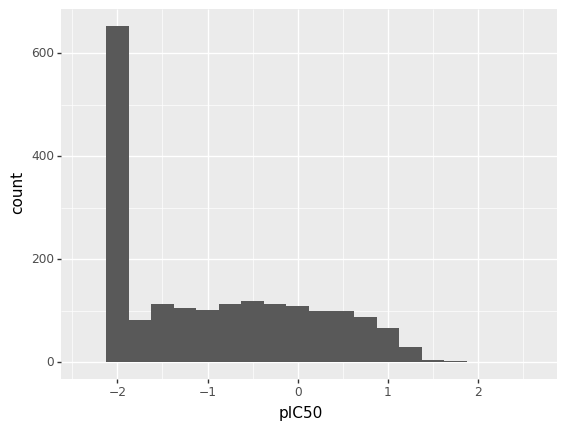

<ggplot: (8727884350925)>

In [47]:
rows_to_drop = all_comps[all_comps["f_avg_IC50"] == ""].index.values.tolist()
rows_to_drop = rows_to_drop + (all_comps[pd.to_numeric(all_comps.f_avg_IC50, errors='coerce').isnull()].index.values.tolist())
all_comps.drop(all_comps.index[rows_to_drop], inplace=True)

all_comps["pIC50"] = -np.log10(all_comps["f_avg_IC50"].astype(float))

g = ggplot(aes(x="pIC50"), data = all_comps)
g + geom_histogram(binwidth=0.25)


In [5]:
all_data_file = Path('activity_data.csv')

manager = DatabaseManager(database_path='activity_data.db')
manager.drop_all()
manager.create()
manager.populate_compounds_table(all_data_file=all_data_file)
manager.populate_assays_table(all_data_file=all_data_file)


manager.get_conn().commit()

df = pd.read_sql_query("SELECT CID, smiles from compounds", manager.get_conn())


# Cluster by Tanimoto similarity 
Alows for vertical splits of data into train and test sets.  
Pair-wise Tanimoto similarity scores generated, followed by Butina clustering.

In [6]:
# compute fingerprint  
df['fingerprint'] = df.smiles.apply(lambda x : AllChem.GetMorganFingerprint(Chem.MolFromSmiles(x),2))

#Define clustering setup
def ClusterFps(fps,cutoff=0.2):
    from rdkit import DataStructs
    from rdkit.ML.Cluster import Butina

    # first generate the Tanimoto matrix
    dists = []
    nfps = len(fps)
    for i in range(1,nfps):
        sims = DataStructs.BulkTanimotoSimilarity(fps[i],fps[:i])
        dists.extend([1-x for x in sims])

    # now cluster the data:
    cs = Butina.ClusterData(dists,nfps,cutoff,isDistData=True)
    return cs

# Clustering
Investigating the effect of cutoff on number of clusters generated.
Using Butina clustering.
Will use a cutoff of 0.5 which gives 32 clusters.


[1829, 1381, 917, 609, 398, 269, 144, 44, 7]


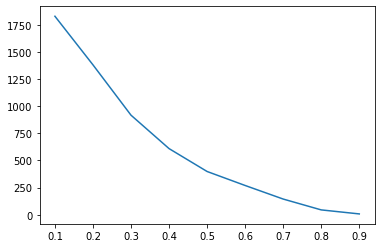

In [7]:
# cutoffs to explore
cutoffs = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
cutoff_clusters = []
for cutoff in cutoffs:
    cutoff_clusters.append(ClusterFps(df.fingerprint.tolist(), cutoff=cutoff))
n_clusters = list(len(x) for x in cutoff_clusters)
import matplotlib.pyplot as plt
plt.plot(cutoffs,n_clusters)
print(n_clusters)


A similarity cutoff of 0.4 was selected in order to have sufficient clusters of small enough size to seperate into an 80:20 split.

In [8]:
clusters_0_4 = cutoff_clusters[3]

# determine which cluster each molecule is in 
def find_cluster(clusters, item):
    for i, cluster in enumerate(clusters):
        if item in cluster:
            return i
# write cluster number of pandas df
df['clusters'] =  df.index.map(lambda x : find_cluster(clusters_0_4, x))


# Training split
Use a vertical split to create train and test set using 80/20 split by cluster.
Randomly allocate clusters to test until >20%. 

In [9]:
import random
target_test_size = len(df) * 0.2
test_size = 0
test_clusters = []
cluster_sizes = dict(df.clusters.value_counts())
while test_size < target_test_size:
    random_cluster = random.choice(list(cluster_sizes.keys()))
    size = cluster_sizes.pop(random_cluster)
    test_clusters.append(random_cluster)
    test_size += size
print(test_size, target_test_size)
df['test'] = df.clusters.apply(lambda x: True if x in test_clusters else False)
df.to_pickle('pandas_dumps/compounds_split.pkl')



427 407.40000000000003


In [1]:
import graphing 
# Load in data 
train_split = pd.read_pickle("pandas_dumps/compounds_split.pkl")
all_data = pd.read_csv("activity_data.csv")

In [2]:
import seaborn as sn
import math
def test_model(X_test, y_test, automl):
    print('Best ML leaner:', automl.best_estimator)
    print('Best hyperparmeter config:', automl.best_config)
    print('Best accuracy on validation data: {0:.4g}'.format(1-automl.best_loss))
    print('Training duration of best run: {0:.4g} s'.format(automl.best_config_train_time))
    # Test set performance
    preds = automl.predict(X_test)
    labels = y_test
    correlation = np.corrcoef(preds,labels)[0,1]
    sn.set(style="darkgrid")

    rmse = math.sqrt(((preds - labels)**2).mean())
    plt.figure()
    h = sn.jointplot(
        x=labels,
        y=preds,
        kind='reg',
        joint_kws={"scatter_kws":{'alpha':0.2, 'edgecolors':'white'}, "label":f"correlation: {correlation}",} )
    h.set_axis_labels('Experimental pK', 'Predicted pK')
    h.fig.suptitle(f"Test Set Predictions - R: {correlation:.2f}, RMSE: {rmse:.2f}")

In [3]:
# Merge the training split with the all_data column
all_data = all_data.merge(right=train_split,how="right")
# drop any record that has nan for f_avg_
all_data = all_data[all_data['f_avg_IC50'].notna()]
# calculate the pIC50
all_data['pIC50'] = - all_data.f_avg_IC50.apply(np.log10)

# Training on molecular fingerprints
Using a 2048-bit molecular fingerprint using ECFP4 as training data, predicting on pIC50. 

Training performed using FLAML AutoML, automatic selection of best performing model as well as hyperperameters. Data is split vertically into a 80% training set and 20% test set. 

In [4]:
from flaml import AutoML
X_train_list = all_data[  ~all_data['test']]['fingerprint']
y_train = all_data[  ~all_data.test]['pIC50']
y_train = y_train.to_numpy()
X_train = []

X_test_list = all_data[  all_data['test']]['fingerprint']
y_test = all_data[  all_data.test]['pIC50']
y_test = y_test.to_numpy()
X_test = []

# Convert from rdkit format to numpy
from rdkit.DataStructs import cDataStructs
for fp in X_train_list:
    array = np.zeros((0, ), dtype=np.int8)
    cDataStructs.ConvertToNumpyArray(fp, array)
    X_train.append(array)
X_train = np.array(X_train)

for fp in X_test_list:
    array = np.zeros((0, ), dtype=np.int8)
    cDataStructs.ConvertToNumpyArray(fp, array)
    X_test.append(array)
X_test = np.array(X_test)


In [10]:
# Initialize an AutoML instance
automl = AutoML()
# Specify automl goal and constraint
automl_settings = {
    "metric": 'r2',
    "time_budget": 180,
    "task": 'regression',
    "log_file_name": "fingerprint.log",
}
# Train with labeled input data
automl.fit(X_train=X_train, y_train=y_train,
           **automl_settings)

[flaml.automl: 01-28 12:18:36] {2007} INFO - task = regression
[flaml.automl: 01-28 12:18:36] {2009} INFO - Data split method: uniform
[flaml.automl: 01-28 12:18:36] {2013} INFO - Evaluation method: holdout
[flaml.automl: 01-28 12:18:36] {2113} INFO - Minimizing error metric: 1-r2
[flaml.automl: 01-28 12:18:36] {2170} INFO - List of ML learners in AutoML Run: ['lgbm', 'rf', 'xgboost', 'extra_tree', 'xgb_limitdepth']
[flaml.automl: 01-28 12:18:36] {2437} INFO - iteration 0, current learner lgbm
[flaml.automl: 01-28 12:18:49] {2551} INFO - Estimated sufficient time budget=134977s. Estimated necessary time budget=952s.
[flaml.automl: 01-28 12:18:49] {2603} INFO -  at 13.8s,	estimator lgbm's best error=0.7397,	best estimator lgbm's best error=0.7397
[flaml.automl: 01-28 12:18:49] {2437} INFO - iteration 1, current learner lgbm
[flaml.automl: 01-28 12:18:51] {2603} INFO -  at 15.0s,	estimator lgbm's best error=0.7397,	best estimator lgbm's best error=0.7397
[flaml.automl: 01-28 12:18:51] {2

Best ML leaner: lgbm
Best hyperparmeter config: {'n_estimators': 9, 'num_leaves': 14, 'min_child_samples': 10, 'learning_rate': 0.41503625524940313, 'log_max_bin': 9, 'colsample_bytree': 0.901715410746528, 'reg_alpha': 0.02314694463413697, 'reg_lambda': 2.83388282149027}
Best accuracy on validation data: 0.5703
Training duration of best run: 4.081 s


<Figure size 432x288 with 0 Axes>

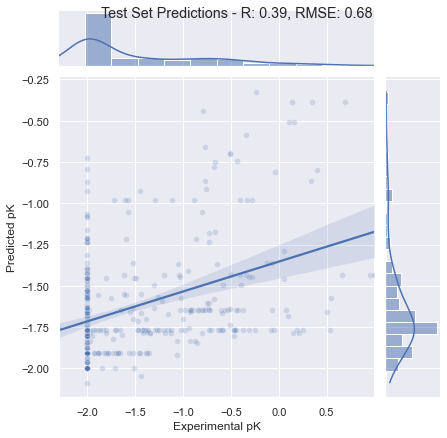

In [11]:
test_model(X_test, y_test, automl)


# Training on features
Initially using unscaled features.

In [11]:
# combine features df with the train_split df
featurised = pd.read_pickle("pandas_dumps/featurised_compounds.pkl")
featurised = featurised.merge(right=train_split,how="left")
# extract features columns
feature_columns = featurised.columns[9:-4]
# train data
X_train = featurised[  ~featurised['test']][feature_columns]
X_train = X_train.to_numpy()
y_train = featurised[  ~featurised['test']]['pIC50']
y_train = y_train.to_numpy()
# test data 
X_test = featurised[  featurised['test']][feature_columns]
X_test = X_test.to_numpy()
y_test = featurised[  featurised['test']]['pIC50']
y_test = y_test.to_numpy()

In [16]:
from sklearn import set_config
from flaml import AutoML

set_config(display='diagram')

# Initialize an AutoML instance
automl = AutoML()
# Specify automl goal and constraint
automl_settings = {
    "time_budget": 300,  # in seconds
    "metric": 'r2',
    "task": 'regression',
    "log_file_name": "featurised.log",
}
# Train with labeled input data
automl.fit(X_train=X_train, y_train=y_train,
           **automl_settings)

print(automl.model.estimator)

[flaml.automl: 01-28 10:53:22] {2007} INFO - task = regression
[flaml.automl: 01-28 10:53:22] {2009} INFO - Data split method: uniform
[flaml.automl: 01-28 10:53:22] {2013} INFO - Evaluation method: cv
[flaml.automl: 01-28 10:53:22] {2113} INFO - Minimizing error metric: 1-r2
[flaml.automl: 01-28 10:53:22] {2170} INFO - List of ML learners in AutoML Run: ['lgbm', 'rf', 'xgboost', 'extra_tree', 'xgb_limitdepth']
[flaml.automl: 01-28 10:53:22] {2437} INFO - iteration 0, current learner lgbm
[flaml.automl: 01-28 10:53:22] {2551} INFO - Estimated sufficient time budget=4231s. Estimated necessary time budget=30s.
[flaml.automl: 01-28 10:53:22] {2603} INFO -  at 0.5s,	estimator lgbm's best error=0.7511,	best estimator lgbm's best error=0.7511
[flaml.automl: 01-28 10:53:22] {2437} INFO - iteration 1, current learner lgbm
[flaml.automl: 01-28 10:53:22] {2603} INFO -  at 0.7s,	estimator lgbm's best error=0.7511,	best estimator lgbm's best error=0.7511
[flaml.automl: 01-28 10:53:22] {2437} INFO 

ExtraTreesRegressor(max_features=0.5423047717160484, max_leaf_nodes=69,
                    n_estimators=80, n_jobs=-1)


Best ML leaner: extra_tree
Best hyperparmeter config: {'n_estimators': 80, 'max_features': 0.5423047717160484, 'max_leaves': 69}
Best accuracy on validation data: 0.6049
Training duration of best run: 0.5601 s


<Figure size 432x288 with 0 Axes>

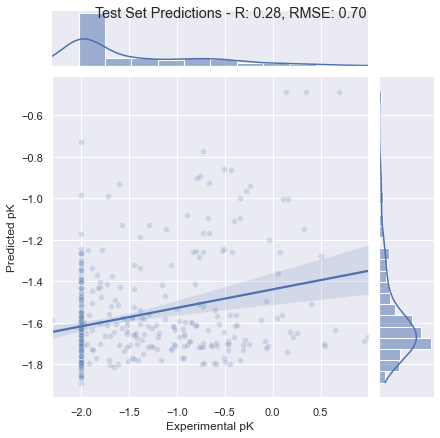

In [17]:
test_model(X_test, y_test, automl)


# Featurised with standardisation of data
Features scaled to give a mean of 0 and variance of 1. 

In [8]:
from sklearn import preprocessing

automl = AutoML()

scaler = preprocessing.StandardScaler().fit(X_train)
X_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Specify automl goal and constraint
automl_settings = {
    "time_budget": 300,  # in seconds
    "metric": 'r2',
    "task": 'regression',
    "log_file_name": "featurised.log",
}
automl.fit(X_scaled, y_train,
                    **automl_settings)

print(automl.model.estimator)


[flaml.automl: 01-28 12:08:07] {2007} INFO - task = regression
[flaml.automl: 01-28 12:08:07] {2009} INFO - Data split method: uniform
[flaml.automl: 01-28 12:08:07] {2013} INFO - Evaluation method: holdout
[flaml.automl: 01-28 12:08:08] {2113} INFO - Minimizing error metric: 1-r2
[flaml.automl: 01-28 12:08:08] {2170} INFO - List of ML learners in AutoML Run: ['lgbm', 'rf', 'xgboost', 'extra_tree', 'xgb_limitdepth']
[flaml.automl: 01-28 12:08:08] {2437} INFO - iteration 0, current learner lgbm
[flaml.automl: 01-28 12:08:12] {2551} INFO - Estimated sufficient time budget=48112s. Estimated necessary time budget=339s.
[flaml.automl: 01-28 12:08:12] {2603} INFO -  at 5.1s,	estimator lgbm's best error=0.7397,	best estimator lgbm's best error=0.7397
[flaml.automl: 01-28 12:08:12] {2437} INFO - iteration 1, current learner lgbm
[flaml.automl: 01-28 12:08:15] {2603} INFO -  at 7.5s,	estimator lgbm's best error=0.7397,	best estimator lgbm's best error=0.7397
[flaml.automl: 01-28 12:08:15] {2437

LGBMRegressor(learning_rate=0.44269599900286055, max_bin=255,
              min_child_samples=9, n_estimators=9, num_leaves=30,
              reg_alpha=0.08886913900816325, reg_lambda=0.48022344435728026,
              verbose=-1)


Best ML leaner: lgbm
Best hyperparmeter config: {'n_estimators': 9, 'num_leaves': 30, 'min_child_samples': 9, 'learning_rate': 0.44269599900286055, 'log_max_bin': 8, 'colsample_bytree': 1.0, 'reg_alpha': 0.08886913900816325, 'reg_lambda': 0.48022344435728026}
Best accuracy on validation data: 0.5993
Training duration of best run: 0.5661 s


<Figure size 432x288 with 0 Axes>

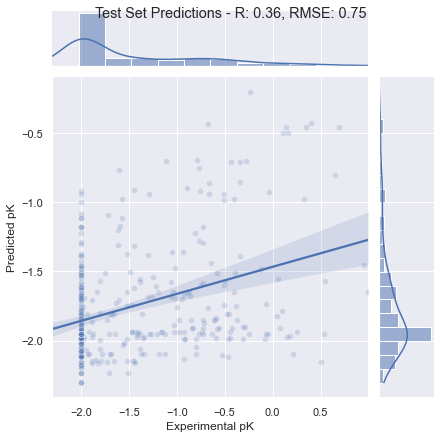

In [9]:
test_model(X_test_scaled,y_test,automl)